## Chapter 8. 신경망, 딥러닝 응용(필기체 숫자 인식)

### 8.1 MINST 데이터 설명(데이터베이스)

- 각 이미지는 28 * 28 행렬로, 0 ~ 255(pixel값)의 값을 가짐
- 0 ~ 9까지의 손글씨(필기체) label이 존재
- Train data: 60,000 / Test data : 10,000 

In [ ]:
# MNIST 데이터 불러오기 
from keras.datasets import mnist                         # keras Database에 있는 mnist 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()  # 데이터 할당

11501568/11490434 [==============================] - 0s 0us/step


#### 참고자료

![color_ragne](https://processing.org/440ee3e47245e39066409dfd3a53a8a9/grayscale.svg)

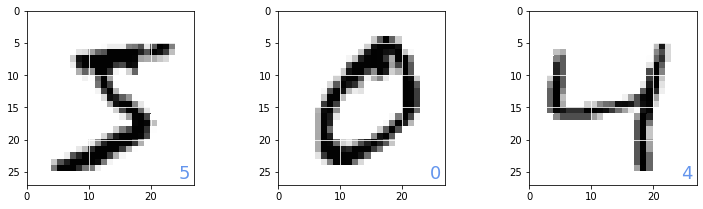

In [ ]:
# MNIST 데이터 시각화 

## 필요 모듈 불러오기
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 시각화
plt.figure(1, figsize=(12, 3.2)) 
plt.subplots_adjust(wspace=0.5)   # plot 사이 간격: 0.5 
plt.gray()

for id in range(3):              # 데이터 일부 시각화(3개)
    plt.subplot(1, 3, id + 1)
    img = x_train[id, :, :]      # 각 이미지별 pixel 값(28*28)
    plt.pcolor(255 - img)        # 글자를 표기하기 위해서 대비
    plt.text(24.5, 26, "%d" % y_train[id],color='cornflowerblue', fontsize=18)  # label값 표시(우측하단)
    plt.xlim(0, 27)
    plt.ylim(27, 0)
    plt.grid('on', color='white')
plt.show()

### 8.2 2 Feedforward Network Model
- 2층 피드 포워드 네트워크 모델을 사용하여 필기체 숫자 클래스 분류 문제 해결

#### [1] 데이터 변형
- 28 * 28 image 데이터를 784 array 형식으로 반환(단순하게 Flatten)
- 정규화(pixel의 최대값 255 나눔 -> 0 ~ 1사이의 값으로 변환
- label(y)는 1-of-k 부호화 변환  
 $\Rightarrow$ np_utils.to_categorical(): One-hot encoding(10진수 형식 -> 2진수 binary 형식 변환) / 2번째 인수: 배열의 크기 

In [ ]:
# 데이터 변형
from keras.utils import np_utils

## Train data 변환
x_train = x_train.reshape(60000, 784) # 28 * 28 -> 784 vector (배열) 변환 
x_train = x_train.astype('float32')   # 실수 변환
x_train = x_train / 255               # 정규화(0 ~ 1 사이로) 

num_classes = 10
y_train_prior = y_train.copy()
y_train = np_utils.to_categorical(y_train, num_classes)  # y_train값 one-hot encoding(1-of-k 부호화)

## np_utils.to_categorical 결과 차이 확인
print("부호화 처리하기 전: {}".format(y_train_prior[:5]))
print("부호화 처리하기 후: \n {}".format(y_train[:5]))

## Test data 변환(Train과 동일하게 처리)
x_test = x_test.reshape(10000, 784)
x_test = x_test.astype('float32')
x_test = x_test / 255
y_test = np_utils.to_categorical(y_test, num_classes)

부호화 처리하기 전: [5 0 4 1 9]
부호화 처리하기 후: 
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


#### [2] Model network 

1. Sequential
- model로 선언 후, model.add를 통해 층을 단계적으로 추가

2. Dense Layer  <br>  
- 입력과 출력을 모두 연결하며, 각각 연결해주는 가중치를 포함 <br>    
- 첫번째 인자(출력 뉴런/노드 수를 결정), 두번째 인자(입력 뉴런/노드 수, 맨처음 입력층에서만 사용), 세번째 인자(활성화 함수) <br>    
- 코드: model.add(Dense(16, input_dim=784, activation='sigmoid')): 입력 784, 출력 16 -> 가중치 784 * 16개 존재  <br>  
  
3. 요약(summary()) <br>
- 모델의 정보를 요약

4. 컴파일(compile) <br>
- 모델이 기계가 이해할 수 있도록 compile 함 / 손실함수, optimizer, metrix를 정의
- 코드: model.compile(loss function, optimizer, metrics) 
<br>

[1] optimizer: loss function을 기반으로 Network를 updata 방식(훈련 과정 설정)  
[2] loss function: 훈련 과정에서 사용할 loss 함수  
[3] metrics: 훈련을 모니터링하기 위한 지표  
- 대표적인 사용되는 손실함수와 활성화 함수 조합

| 문제 유형       | 손실 함수명                     | 출력층 활성화 함수 
| ----------------|---------------------------------|-------------------|
| 회귀 문제       | mean-squared-error(MSE)         |         -         | 
| 다중 클래스 문제| categorical-crossentropy        |     softmax       |
| 다중 클래스 문제| sparse-categorical-crossentropy |     softmax       |
| 이진 분류 문제  | binary-crossentropy             |     sigmoid       |

5. 학습(fit) <br>
- 모델 학습(훈련, 적합): 모델이 error로부터 paramter를 updata하는 과정
- 변수에 할당할 경우 결과값(loss, metrics)를 불러올 수 있음
- 코드: model.fit(훈련 데이터, label 데이터, epoch, batch size, verbose, validation data, validation_split) 
<br>

[1] epoch: 학습 갱신 횟수(총 훈련 횟수)를 정하는 매개 변수 / 1 epoch = 전체 데이터를 1번 학습을 하였다는 의미  
[2] batch size : 미니 배치 경사 하강법 사용(loss function weight를 계산하는 배치 크기)  
[3] validation_data: 검증용 데이터를 사용(epoch 마다 모델 성능 확인 / 학습하지 않음)  
[4] validation_split: validation data 대용으로 사용 가능(데이터 지정하는 것이 아닌 train 일정 비율 분리하여 검증 데이터)   
[5] verbose: 학습 중 출력 문구 설정(0: 출력하지 않음, 1: 훈련 진행 바를 시각화 2: 미니 배치마다 손실정보 출력

6. 평가(evalutate)  <br>
- Test data를 통해 학습 모델에 대한 평가 

7. 기타 
- predict: 임의의 입력데해나 모델의 출력 값
- save: 모델 저장
- load_mode: 모델 불러오기


#### 기타 내용 정리 (경사하강법 종류 3가지 / optimizer 정리 必)


In [ ]:
# 모델 네트워크 정의 및 학습
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import time

## 모델 네트워크 정의  
np.random.seed(1)
model = Sequential()                                      # sequential 모델 object 정의하기
model.add(Dense(16, input_dim=784, activation='sigmoid')) # 중간 layer 추가(입력 차원[노드]: 28 * 28, 중간 layer node 수: 16) : 은닉층
model.add(Dense(10, activation='softmax'))                # 출력 layer 추가(출력 layer node 수 : 10[label 수]) 
model.summary()                                           # 모델의 정보 요약

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                12560     
                                                                 
 dense_5 (Dense)             (None, 10)                170       
                                                                 
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy']) 

## 모델 학습 & 평가: validataion data를 test 데이터로 구축하지 않고 train 데이터 내에서 25%를 validation 사용
startTime = time.time()                                                                                     # 현재 timestamp 얻기
history = model.fit(x_train, y_train, epochs=10, batch_size=1000, verbose=1, validation_split = 0.20)      # 모델 학습
score = model.evaluate(x_test, y_test, verbose=0)                                                          # 모델 평가

## 모델 Test 에디어 결과 출력
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))

Epoch 1/10
48/48 [==============================] - 2s 7ms/step - loss: 2.0880 - accuracy: 0.3160 - val_loss: 1.8156 - val_accuracy: 0.5222
Epoch 2/10
48/48 [==============================] - 0s 4ms/step - loss: 1.6636 - accuracy: 0.6056 - val_loss: 1.5009 - val_accuracy: 0.6967
Epoch 3/10
48/48 [==============================] - 0s 4ms/step - loss: 1.4067 - accuracy: 0.7086 - val_loss: 1.2797 - val_accuracy: 0.7574
Epoch 4/10
48/48 [==============================] - 0s 4ms/step - loss: 1.2137 - accuracy: 0.7694 - val_loss: 1.1078 - val_accuracy: 0.8076
Epoch 5/10
48/48 [==============================] - 0s 4ms/step - loss: 1.0622 - accuracy: 0.8058 - val_loss: 0.9733 - val_accuracy: 0.8359
Epoch 6/10
48/48 [==============================] - 0s 4ms/step - loss: 0.9430 - accuracy: 0.8272 - val_loss: 0.8667 - val_accuracy: 0.8498
Epoch 7/10
48/48 [==============================] - 0s 4ms/step - loss: 0.8480 - accuracy: 0.8406 - val_loss: 0.7814 - val_accuracy: 0.8619
Epoch 8/10
48/48 [==

#### 경사하강법 종류
[0] Total Trainning Dataset Batch gRADEINT dESCENT(BGD)
- 전체 데이터 셋에 대해 에러를 구한 뒤 ⇒ 기울기를 한번만 계산하여 모델의 파라미터를 업데이트 하는 방식

- 장점: 전체 데이터 set에 대한 Error Gradeint을 계산 학습 자체는 안정적
- 단점: Local minimum에 빠질 경우 탈출이 어려움 / 전체 데이터에 대해서 업데이트가 이루어져 업데이트 횟수 자체도 적고, 계산 자체가 오래 걸림


[1] Stochastic Gradient Descent (SGD)
- 추출된 각각 한개의 데이터에 대해서 Gradient 계산 후 업데이트 하는 알고리즘
- 확률적이기에 불안정하여 아래와 같이 요동 / 그러나 이러한 요동침이 Local Minimum의 탈출 가능성을 만들어줌

- 장점: shooting이 발생 Local Minimum 빠질 리스크가 다소 적어짐
- 단점: Global minimum을 몾찾을 수 있음, 훈련 데이터 한개씩 처리함으로 GPU 성능을 전부다 활용하지 못함

![sgd](https://t1.daumcdn.net/cfile/tistory/99AA2333601B4C5810?original)

[2] Mini Batch Stochastic Gradient Descent
- 전체 데이서셋에서 m개의 데이터를 뽑아서 N개의 mini batch를 만들고

- 장점
(1) shooting이 BGD보다는 발생하므로 local minimum 빠질 가능성이 상대적으로 적음 
(2) SGD보다는 GPU 성능을 활용한 병렬처리가 가능하여 속도적으로 유리 
(3) 전체 데이터 아닌 일부 데이터만 메모리에 적재하기 때문에 메모리 사용측면에서도 BGD보다 원할
- 단점: mini batch의 batch size가 일종의 parameter 역할 

![minibatch](https://t1.daumcdn.net/cfile/tistory/99AD3043601B4C5812?original)

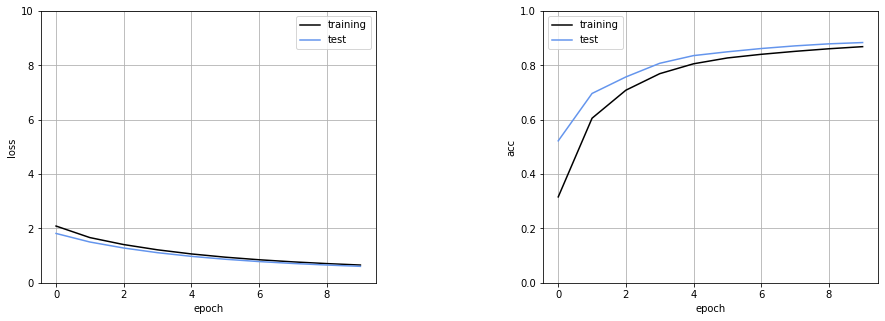

In [ ]:
ㄴ# 모델 학습 과정 시각화(loss 및 정확도 epoch별 변화)
plt.figure(1, figsize=(15, 5))
plt.subplots_adjust(wspace=0.5)

## train & validation loss 변화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='training', color='black')
plt.plot(history.history['val_loss'], label='test', color='cornflowerblue')
plt.ylim(0, 10)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

## train & validation accuracy 변화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='training', color='black')
plt.plot(history.history['val_accuracy'],label='test', color='cornflowerblue')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

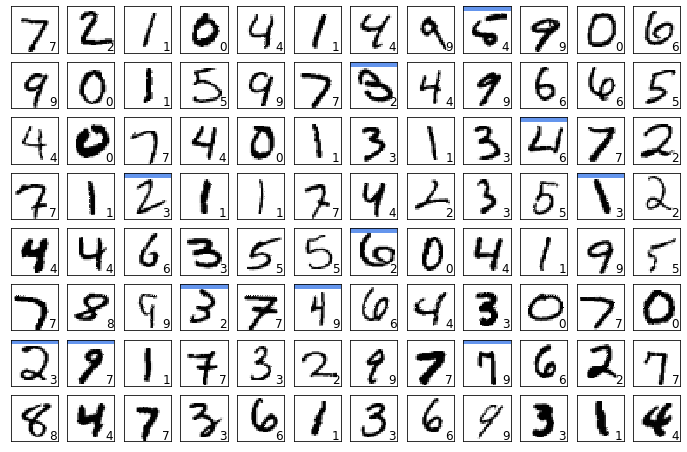

In [ ]:
# 모델의 테스트 데이터에 대한 (예측) 출력 결과 함수
def show_prediction():
    n_show = 96                    # 시각화할 데이터 개수
    y = model.predict(x_test)      # testb data에 대한 모델의 예측값(각 class의 확률값) 
    plt.figure(2, figsize=(12, 8))
    plt.gray()
    
    for i in range(n_show):
        plt.subplot(8, 12, i + 1)
        x = x_test[i, :]           # 앞선 데이터 변형 간 Flatten된 데이터(array) -> 28 * 28 size 변환
        x = x.reshape(28, 28)
        plt.pcolor(1 - x)
        wk = y[i, :]
        prediction = np.argmax(wk) # 데이터 예측값(확률값중 max 해당하는 idx)
        plt.text(22, 25.5, "%d" % prediction, fontsize=12)  # 데이터 label를 우측 하단의 표시
        if prediction != np.argmax(y_test[i, :]):          # 모델이 잘못 예측한 데이터 표시(오른쪽 상단에 blue bar 표시)
            plt.plot([0, 27], [1, 1], color='cornflowerblue', linewidth=5)
        plt.xlim(0, 27)
        plt.ylim(27, 0)
        plt.xticks([], "")
        plt.yticks([], "")

# 시각화
show_prediction()
plt.show()

#### [3] 결과 정리

- Test 정확도: 88.64% (overfitting은 일어나지 않음 / 순조롭게 학습이 되었음)
- 실제 Test data에서 제대로 예측하지 못한 데이터가 일부 있음(10개)
- 결과값은 가중치 매개 변수의 초기값(parameter intialization)에 의존하여 다른 값을 보임
    >> parameter의 초기값에 따라 loss function minimum(local or global) 조금식 달라지기 때문(parameter value 변화)

### 8.3 ReLU activation function
- 앞선 2 feedforward Network 중간층(은닉층) 활성화 함수를 sigmoid에서 ReLU로 변환해 성능 비교 

#### [0]  들어가기 전(Activiation Function)
- Model Network의 비선형(nonlinearity)를 추가하기 위해 사용
 
#### [1] Sigmoid 특징 및 한계점
![sigmoid](https://t1.daumcdn.net/cfile/tistory/990714335981FE1118)

<br>

- 수식
$$ y = \sigma(a) = \frac{1}{1+exp(-a)} $$

- 특징  <br>
    1) 결과값이 0 ~ 1 사이 제한, 뇌의 Neron과 유사하여 많이 사용  
    2) 연속형 데이터가 매끄럽게 변환한 되며, 동시에 이상치가 들어오더라도 0과 1 사이의 값만 나오기 때문에 해결할 수 있음 
<br>

- 장점  
    1) 출력 값이 0 ~ 1 사이 + 매끄러운 곡선으로 Gradient Exploding(기울기 폭주) 기울기가 급격하게 발산하는 문제  
    2) 출력 값이 어느 값에 가까운지를 통해서 (이진) 분류를 쉽게 할 수 있음 
<br>  

- 문제점  
    1) Gradient Vanishing(사라지는 경사 문제)
    -> 입력 x가 어느정도 커지면 1에 가까운 값을 출력하기 때문에 입력의 변화가 출력에 반영하기 어려움  
    -> 편미분의 최대값이 0.25, 경사하강법의 학습이 늦어지며, layer가 깊어질수록 0에 가까운 값이 되어 Gradient가 죽는 현상 발생  
    2) 계산 결과값이 복잡함(지수)

#### [2] ReLU (after / 미분 추가)
![ReLU](https://t1.daumcdn.net/cfile/tistory/99DED43C5AB61D1927)
<br>

- 수식 
$$ y = max(0,x)$$

- 특징  <br>
    1) Nerual Network 많이 사용하는 Activiation Function  
    2) 입력값이 0보다 작으면 0이고, 0보다 크면 그대로 내보냄  
<br>

- 장점  
    1) 양수(>0) 부분이 선형함수임으로 미분 계산이 효율적, 수렴속도가 sigmoid 대비 6배 빠름(학습 정체 문제 해결)  
    2) 음수(<0), 0 이하의 입력에 대해서는 0을 출력함으로써 부분적으로 활성화(sparse activation)  
    3) scale invariant(scale의 불변성): $ max(0,ax) = a * max(0,x) $
<br>  

- 문제점  
    1) 입력값이 음수 0인 경우, 항상 0을 출력(parameter updata가 진행이 안됨)  
    2) 중심값이 0이 아님

#### [3] Gradient Vanishing, Gradient Exploding(after)
- sigmoid의 함수 출력 값의 중앙 값이 0.5이며, 모두 양수이기 때문에 출력의 가중치 합이 입력이 가중치 합보다 커짐(편향 이동)
- sigmoid의 출력 값 모두 양수이기 때문에 기울이가 모두 양수 혹은 음수 -> 기울기 updata 진행과정이 지그재그 변동하는 결과로 오고 학습 효율성이 낮음

(1) Gradinet Vanishing
- 역전파 과정에서 입력층으로 갈수록 기울기(Gradient)가 점차적으로 작아지는 현상
<br>
- 입력층에 가까운 층에서 가중치가 업데이트가 제대로 되지 않으면 결국 최적의 모델을 찾을 수 없게 됨 <br>

(2) Gradient Exploding
- 기울기가 점차 커지더니 가중치들이 비정상적으로 큰 값이 되면서 결국 발산이 되는 현상

(3) 공통점
- 모델이 깊이가 깊어질수록(layer가 커질수록)
- input region을 작은 output region으로 맵핑하고, 그것이 2차 3차 레이어로 갈수록 더 심각하게 작은 region으로 맵핑


#### [4] 결과 정리 
- 정확도 개선: Test 데이터 기준 88.64% -> 92.17% 향상 / 실제 Test 데이터 내에서의 오답 개수 10개 -> 7개로 변화

Epoch 1/10
48/48 [==============================] - 1s 7ms/step - loss: 1.5920 - accuracy: 0.5027 - val_loss: 0.9985 - val_accuracy: 0.7494
Epoch 2/10
48/48 [==============================] - 0s 4ms/step - loss: 0.7758 - accuracy: 0.8149 - val_loss: 0.5625 - val_accuracy: 0.8682
Epoch 3/10
48/48 [==============================] - 0s 4ms/step - loss: 0.5155 - accuracy: 0.8709 - val_loss: 0.4252 - val_accuracy: 0.8901
Epoch 4/10
48/48 [==============================] - 0s 4ms/step - loss: 0.4203 - accuracy: 0.8900 - val_loss: 0.3665 - val_accuracy: 0.9016
Epoch 5/10
48/48 [==============================] - 0s 4ms/step - loss: 0.3739 - accuracy: 0.8986 - val_loss: 0.3342 - val_accuracy: 0.9082
Epoch 6/10
48/48 [==============================] - 0s 4ms/step - loss: 0.3445 - accuracy: 0.9056 - val_loss: 0.3135 - val_accuracy: 0.9141
Epoch 7/10
48/48 [==============================] - 0s 4ms/step - loss: 0.3245 - accuracy: 0.9111 - val_loss: 0.3006 - val_accuracy: 0.9167
Epoch 8/10
48/48 [==

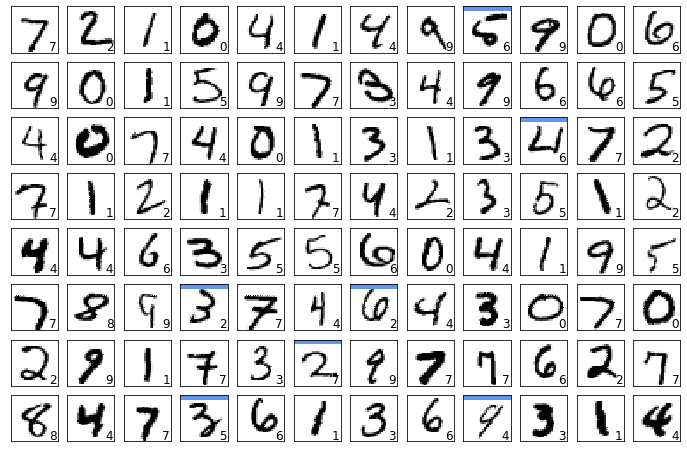

In [ ]:
# Activation Function 변화(sigmoid -> ReLU)에 따른 학습 결과 비교

## sigmoid 함수와 동일하게 구성
np.random.seed(1)
model = Sequential()
model.add(Dense(16, input_dim=784, activation='relu')) 
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

startTime = time.time()
history = model.fit(x_train, y_train, batch_size=1000, epochs=10, verbose=1, validation_split = 0.20)
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 동일하게 Test 데이터로 결과 비교
show_prediction()
plt.show()

#### [5] 네트워크 모델 중간층 가중치 매개 변수 시각화

##### 은닉층(중간층) Layer의 가중치 시각화 
- 가중치의 값이 양수이면 검은색, 음수이면 흰색  
    => 가중치가 양수인 부분(검은색 부분)에 문자가 있으면 neuron이 활성화 / 가중치가 음수인 부분(흰색 부분)에 문자가 있으면 억제   
- 해당 layer 가중치 값은 학습에 의해 획득한 것

#### [6] 한계점
- 본 모델(2 feedforwa Network Model)의 경우 입력 2차원 이미지의 공간정보를 활용하지 않음 
- 28 * 28 image를 784 array 배열로 전개하여 입력 값으로 사용
- 화소 정렬 순서가 네트워크의 성능의 영향력을 못 미침(전결합형으로 모든 입력 성분이 대등한 관계이기 때문)

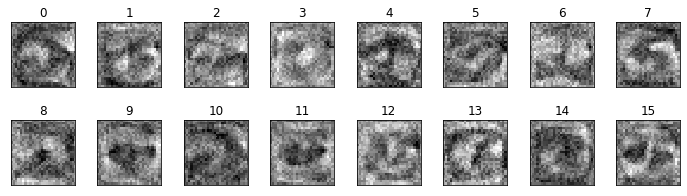

In [ ]:
w = model.layers[0].get_weights()[0]
plt.figure(1, figsize=(12, 3))
plt.gray()
plt.subplots_adjust(wspace=0.35, hspace=0.5)
for i in range(16):
    plt.subplot(2, 8, i + 1)
    w1 = w[:, i]
    w1 = w1.reshape(28, 28)
    plt.pcolor(-w1)
    plt.xlim(0, 27)
    plt.ylim(27, 0)
    plt.xticks([], "")
    plt.yticks([], "")
    plt.title("%d" % i)
plt.show()

### 8.4 공간 필터 

- 공간 정보: 직선, 곡선, 원형 사각형 같은 모양을 나타내는 정보, 데이터 형상 유지하기 위한 정보
- 필터를 통해 공간 정보를 추출하기 위한 이미지 처리 방법 (이미지 일부와 공간 필터 요소를 결합해 이미지의 계산[힙성곱 연산]
<br>

- 원본 이미지 (i, j)의 pixel value x(i,j)를 3 * 3 filter를 h(i, j)하여서 얻으지는 합성곱 결과
$$ g(i,j) = \sum_{u= - 1}^1 \sum_{v= - 1}^1 x(i + u, j + v) h(u + 1, v + 1) $$

- 의미: 중심 위치 i,j에서 같은 크기를 맞춰주기 위해서 식을 사용(좌상단일 경우)

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# (다시 진행) 필요한 모듈 불러오기 
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

# 데이터 할당
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 변형(Train & Test)
x_train = x_train.reshape(60000, 28, 28, 1)             # 이전 2 feed forward Network Model에서와 달리 28 * 28크기 변환
x_train = x_train.astype('float32')                     # train 데이터: (index * height * wideth * channel)
x_train /= 255

num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes) # y값 one-hot encoding(1-of-k 부호화)

x_test = x_test.reshape(10000, 28, 28, 1)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test, num_classes)

#### 코드 참고 사항(reshape)

- reshape에서 "-1"을 사용하는 경우, 변경된 배열의 "-1"위치의 차원은 원래 배열의 길이와 남은 차원으로부터 추정한다는 의미
- 전제조건: 원소의 개수와 reshape의 행과 열의 원소의 조합이 같아야함

[예시를 통한 이해]
- x의 shape (5 * 2)일 경우
- reshape(-1, 정수) : x의 원소가 열개수만큼 자동으로 구조화(예: 정수가 5이면 2 * 5로 정렬)
- reshape(정수, -1) : x의 원소가 행개수만큼 자동으로 구조화(예: 정수가 5이면 5 * 2로 정렬
- reshape(-1)       : x의 원소가 1차원 배열로 구조화

- 참고사항: https://domybestinlife.tistory.com/149 

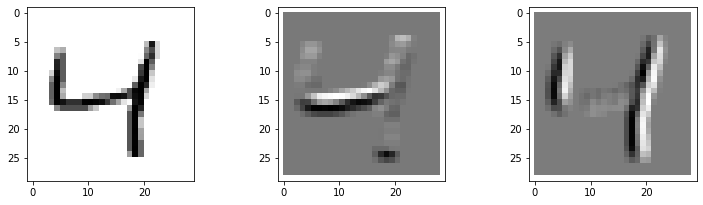

In [ ]:
# 공간 필터 예시
import matplotlib.pyplot as plt
%matplotlib inline

## 필터 정의(예시) 
id_img = 2                                      # 시각화할 image_id(고유값)
myfil1 = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [-2, -2, -2]], dtype=float)  # filter 01: 가로 edge를 가종하는 filter 
myfil2 = np.array([[-2, 1, 1],
                   [-2, 1, 1],
                   [-2, 1, 1]], dtype=float)    # filter 02: 세로 edge를 가종하는 filter 


x_img = x_train[id_img, :, :, 0]               # 데이터 불러오기
img_h, img_w = 28, 28                          # 본 이미지 크기 저의
x_img = x_img.reshape(img_h, img_w)            # 이미지 2차원 형태로 변환(reset 할경우 필요 없음) 

out_img1 = np.zeros_like(x_img)                 # filter(가로 edge)를 적용했을 때 결과를 저장할 matrix 형식 정의
out_img2 = np.zeros_like(x_img)                 # filter(세로 edge)를 적용했을 때 결과를 저장할 matrix 형식 정의

# 필터 처리
for ih in range(img_h - 3):                     # 기존 Image의 height와 weight 크기 대비 -3 하는 이유: filter = 3 * 3
    for iw in range(img_w - 3):
        img_part = x_img[ih:ih + 3, iw:iw + 3]  # img_part: image의 좌상단 기준 3 * 3 부분 추출
        
        ## 추출한 image 일부와 filter의 동일한 위치를 내적
        out_img1[ih + 1, iw + 1] = np.dot(img_part.reshape(-1), myfil1.reshape(-1))  # img_part 1차원 배열 * filter 1차원 배열(내적)
        out_img2[ih + 1, iw + 1] = np.dot(img_part.reshape(-1), myfil2.reshape(-1)) 

# 원본 이미지와 필터 시각화
plt.figure(1, figsize=(12, 3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()

## 원본 이미지(필기체 숫자 데이터)
plt.subplot(1, 3, 1)
plt.pcolor(1 - x_img)
plt.xlim(-1, 29)
plt.ylim(29, -1)

## filter01 시각화
plt.subplot(1, 3, 2)
plt.pcolor(-out_img1)
plt.xlim(-1, 29)
plt.ylim(29, -1)

## filter02 시각화
plt.subplot(1, 3, 3)
plt.pcolor(-out_img2)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.show()

### 8.5 합성곱 신경망
- 이미지의 특징을 추출하는 역할 
- kernal 혹은 filter가 전체 image를 겹칯면서 훑으면서, 이미죄와 커널의 값을 곱하고 모두 더한 값을 출력하는 것을 의미함

![합성곱](https://t1.daumcdn.net/cfile/tistory/994058435C4D232F15)

#### [0] 들어가기 전
- 다양한 변형(대상이 뒤틀림, 이동 등)이 존재하며, MLP의 경우 이런 변형의 민감하게 반응함 / 공간적인 정보가 유실됨 
- 완전연결 계층에 입력할 때는 3차원 데이터를 평평한 1차원 데이터로 평탄화 -> 데이터의 형상 무시
= 완전연결 계층은 형상을 무시하고 모든 이력 데이터를 동등한 뉴런(같은 차원의 뉴런)으로 취급하여 형상에 담긴 정보를 살릴 수 없음


#### 합성곱 효과
- 필터가 특징이 데이터에 있는지 없는 지를 검출할 수 있음

![효과적](https://t1.daumcdn.net/cfile/tistory/9944114C5C4D24F11A)
![효과](https://t1.daumcdn.net/cfile/tistory/991B1E445C4D252419)


#### [1] Channel
- 일반적인 이미지는 (높이, 너비, 채널) 3차원 구조 
- 높이: 이미지의 세로 방향의 픽셀수 / 너비: 이미지의 가로 방향의 픽셀수
- 채널: 색 성분(흑백: 1, 컬러: 컬러 이미지는 적색(Red), 녹색(Green), 청색(Blue) 3가지) 

#### [2] Feature map
- kernal을 사용하여 합성곱 연산을 통해서 나온 결과를 특성 맵(Feature map)으로 불림

#### [2] Padding
- 입력 데이터 주변을 특정 값(예컨대 0, zero padding)으로 채우는 것 
- 합성곱 연산의 결과로 얻은 feature map이 입력보다 작아진다는 특징 
(만약 합성곱 층이 깊어질수록 최종적은 얻은 특성 맵은 초기 입력보다 매우 작아진 값 / 모서리 부분에 특성 파악하는 경우가 적어짐)
1. valid : padding을 하지 않는 것 <br>
2. full: input 모든 요소가 동일한 참여하도록 하는 padding 방식<br>
3. same: 합성곱 연산 ouput 크기를 input 크기를 동일하게 유지되는padding

![패딩](https://wikidocs.net/images/page/64066/conv10.png)

- 만약 스트라이드가 1이라고 하였을 때, <br>  
`-> 3 × 3 크기의 커널을 사용한다면 1 padding 제로 패딩을 사용 <br>  
 -> 5 × 5 크기의 커널을 사용한다면 2 padding 짜리 제로 패딩을 사용하면 입력과 특성 맵의 크기를 보존
<br>  

#### [3] stride
필터를 적용하는 위치의 간격을 스트라이드(stride, 보폭)
![스트라이드](https://t1.daumcdn.net/cfile/tistory/99272D3D5C4D268B1C)

#### [4] 이미지 계산하는 방법
![계산](https://t1.daumcdn.net/cfile/tistory/99972A395C4D270E12)

#### [5] 가중치 &  편향의 의미
- 합성곱 신경망에서 가중치는 커널 행렬의 원소라 볼 수 있음
- 합성곱 연산을 통해서 특성 맵을 얻고, 활성화 함수를 지나는 연산을 하는 합성곱 신경망의 층을 합성곱 신경망에서는 합성곱 층(convolution layer)
![가중치](https://wikidocs.net/images/page/64066/conv12.png)

- 합성곱 신경망에도 편향(bias) 추가한다면 커널을 적용한 뒤에 더함
- 편향은 하나의 값만 존재하며, 커널이 적용된 결과의 모든 원소에 더함

![편향](https://wikidocs.net/images/page/64066/conv14.png)

- https://wikidocs.net/64066
- https://je-d.tistory.com/entry/%ED%95%A9%EC%84%B1%EA%B3%B1-%EC%8B%A0%EA%B2%BD%EB%A7%9DCNN

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#### 코드 설명
conv2D
- 첫 번째 인수 (8, 3x3): 3x3 필터를 8개 사용
- padding = 'Same' 은 입, 출력 크기가 변하지 않도록 패딩을 추가해 처리
- input_shape = (28 , 28 ,1)은 입력 이미지의 크기
- activation = 'relu' 는 필터를 입힌 후의 이미지에 ReLU 활성화함수를 적용

flattenr
- 합성곱층의 출력은 4차: (배치 수, 필터 수, 출력 이미지의 세로폭, 출력 이미지의 가로폭)
- 다음 출력층으로 넣기위해서는 2차원으로 변경해야하는데 그렇게 하기 위해서 Flatten()

In [ ]:
# 합성 신경망 모델 구조를 정의하기 위한 Module 정의
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

import time
np.random.seed(1)

## 모델 구조 정의 
startTime = time.time()

model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', input_shape=(28, 28, 1), activation='relu')) 
model.add(Flatten()) 
model.add(Dense(10, activation='softmax'))
model.summary()

## Model Compile(컴파일)
model.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])


## 모델 학습 및 평가 
history = model.fit(x_train, y_train, batch_size=1000, epochs=20, verbose=1, validation_split = 0.20)
score = model.evaluate(x_test, y_test, verbose=0)

## Test 결과 시각화
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                62730     
                                                                 
Total params: 62,810
Trainable params: 62,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
48/48 [==============================] - 7s 9ms/step - loss: 1.0003 - accuracy: 0.7702 - val_loss: 0.3929 - val_accuracy: 0.8926
Epoch 2/20
48/48 [==============================] - 0s 6ms/step - loss: 0.3595 - accuracy: 0.8970 - val_loss: 0.2956 - val_accuracy: 0.9183
Epoch 3/20
48/48 [================

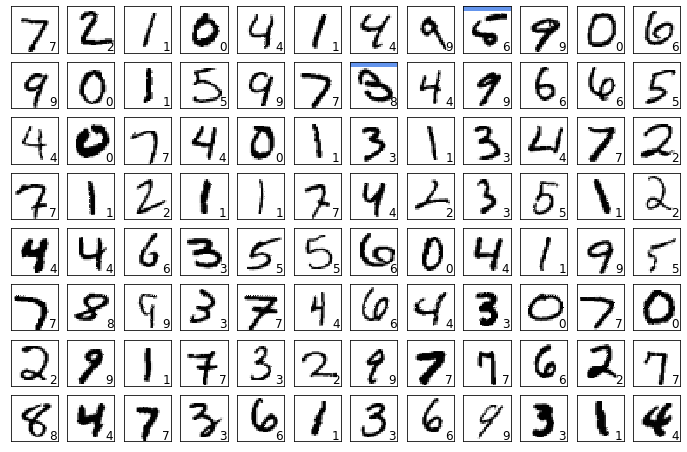

In [ ]:
# 모델의 테스트 데이터에 대한 (예측) 출력 결과 함수: %reset를 했기 때문에 다시 정의해야 함
def show_prediction():
    n_show = 96                    # 시각화할 데이터 개수
    y = model.predict(x_test)      # testb data에 대한 모델의 예측값(각 class의 확률값) 
    plt.figure(2, figsize=(12, 8))
    plt.gray()
    
    for i in range(n_show):
        plt.subplot(8, 12, i + 1)
        x = x_test[i, :]           # 앞선 데이터 변형 간 Flatten된 데이터(array) -> 28 * 28 size 변환
        x = x.reshape(28, 28)
        plt.pcolor(1 - x)
        wk = y[i, :]
        prediction = np.argmax(wk) # 데이터 예측값(확률값중 max 해당하는 idx)
        plt.text(22, 25.5, "%d" % prediction, fontsize=12)  # 데이터 label를 우측 하단의 표시
        if prediction != np.argmax(y_test[i, :]):          # 모델이 잘못 예측한 데이터 표시(오른쪽 상단에 blue bar 표시)
            plt.plot([0, 27], [1, 1], color='cornflowerblue', linewidth=5)
        plt.xlim(0, 27)
        plt.ylim(27, 0)
        plt.xticks([], "")
        plt.yticks([], "")

# 시각화
show_prediction()
plt.show()

#### 결과해석
- 정답률이 약 97% 상당이 개선되는 모습
- 잘못 인식되는 2개로 줄어들음

#### 학습한 Filter 결과 확인
- 예시 : 테스트 데이터 x_test에서 9의 이미지를 적용한 예
- 2번 filter: 가로줄 아래의 edge 강조 
- 7번 filter: 가로줄 위의 edge 강조
- 필터는 자동으로 학습(다른 task의 유용)


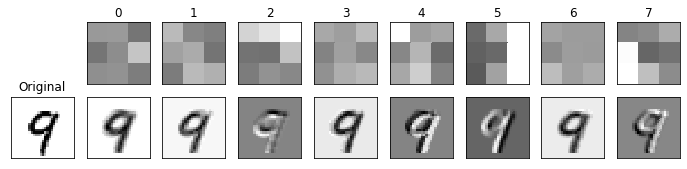

In [ ]:
# 리스트 8-2-(5)
plt.figure(1, figsize=(12, 2.5))
plt.gray()
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.subplot(2, 9, 10)
id_img = 12
x_img = x_test[id_img, :, :, 0]
img_h = 28
img_w = 28
x_img = x_img.reshape(img_h, img_w)
plt.pcolor(-x_img)
plt.xlim(0, img_h)
plt.ylim(img_w, 0)
plt.xticks([], "")
plt.yticks([], "")
plt.title("Original")


w = model.layers[0].get_weights()[0] # (A)
max_w = np.max(w)
min_w = np.min(w)
for i in range(8):
    plt.subplot(2, 9, i + 2)
    w1 = w[:, :, 0, i]
    w1 = w1.reshape(3, 3)
    plt.pcolor(-w1, vmin=min_w, vmax=max_w)
    plt.xlim(0, 3)
    plt.ylim(3, 0)
    plt.xticks([], "")
    plt.yticks([], "")
    plt.title("%d" % i)
    plt.subplot(2, 9, i + 11)
    out_img = np.zeros_like(x_img)
    # 필터 처리
    for ih in range(img_h - 3):
        for iw in range(img_w - 3):
            img_part = x_img[ih:ih + 3, iw:iw + 3]
            out_img[ih + 1, iw + 1] = \
            np.dot(img_part.reshape(-1), w1.reshape(-1))
    plt.pcolor(-out_img)
    plt.xlim(0, img_w)
    plt.ylim(img_h, 0)
    plt.xticks([], "")
    plt.yticks([], "")
plt.show()

### 8.6 풀링
- 이미지의 위치가 어긋나는 등의 배열의 수치가 달라지는 문제를 해결하기 위한 방법
- 입력 이미지가 가로 세로, 어긋나도 변하지 않게 출력하는 성질 
- 세로, 가로 방향의 공간을 줄이는 연산
- 풀링의 윈도우 크기와 스트라이드는 같은 값으로  설정하는 것이 보통
(pooling 중복하지 않음)
- 이것은 지역적인 사소한 변화가 영향을 미치지 않도록 하기 위함

![pooling](https://t1.daumcdn.net/cfile/tistory/993A5B465C4D32D32C)

[1] 최대 풀링(max pooling) : 최대값을 구하는 연산, 2x2 대상 영역에 대하여 가장 큰 원소를 꺼냄

[2] 평균 풀링(average pooling) : 대상 영역에서 평균을 계산. 주로 이미지 인식 분야에서는 최대 풀링을 사용함

- 풀링 계층의 특징

1. 풀링 계층은 합성곱 계층과 달리 학습해야 할 매개 변수가 없다. 대상 영역에서 취하는 명학한 처리!
2. 채널 수가 변하지 않는다. 입력 데이터 채널 수가 3이라면 풀링 후 출력 데이터의 채널 수도 3이다
3. 입력의 변화에 영향을 적게 받는다(강건하다). 입력 데이터가 조금 변해도 풀링의 결과는 잘 변하지 않는다.

![pooling 특징](https://t1.daumcdn.net/cfile/tistory/99CAAB435C4D341122)

<br>

### 8.7 dropout 
- 학습 시 입령층 유닛과 중간층 뉴럴의 확률를 임의의로 선택 후 나머지를 무효화하는 방법
- 무효화된 뉴런은 존재하지 않는 것으로 하여 학습을 갱신하되, mini-bagch바다 뉴런을 뽑아 이 절차를 반복
- 결국 골고루 학습시켜서 일반호하는 작업

#### after(dropout)
![dropout](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdAL0w4%2FbtqCd1WEYoi%2FypDer6gvLoSCJnPM9QdDsk%2Fimg.png)

- 2012년에 발표된 일종의 regulariztation 방법 / 2015년에 발표된 BN(Batch Normalizatoin)의 효과가 regulariztation가 있기 때문에 dropout 없이도 성능이 잘 나와서, 사용하는 여부는 모델 설계자에 문제에 따라서 설정
- 네트워크 일부를 생략하고, 학습을 진행하게 될 경우 생략할 네트워크는 학습에 영향을 미치지 않게 함
- 2가지 문제를 해결(성능을 향상시킬 목적으로 모델 결합 효과를 가지기 위해서 진행 될 서로 다른 데이터를 학습 시키거나 혹은 모델이 서로 다른 구조를 가져야 함 하지만 1. 복수개의 망을 학습하는 것의 어려움 2. 다양한 모델을 실행시킬 때의 response time 요구되는 문제 ) => 여러개의 모델을 학습하는 것 대신 결합 과정에서 voting 비슷한 효과를 냄
- 실제 실행시킬 때(테스트) 생략된 많은 모델을 따로 실행시키는 것이 아니라, 각각의 뉴런이 존속할 확률 p만큼 학습을 진행하고, 실행할 때 각각의 가중치에 존속할 확률로 곱해줌
- 왜 그렇다면 regulariztation 효과가 있을까? 
(1) 학습 과정에서 Network weight드링 서로 동조되는 현상(co-adaption)이 발생하는데, 랜덤하게 생략시키면서 이런 현상을 피할 수 있음( 더 선명한 피쳐를 생성할 수 있음) <br>
(2) hidden neuron 활성도가 sparsity 해짐: 활성화도가 집중되어짐

- 참고자료: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=laonple&logNo=220818841217

### 8.8 MNIST 인식 네트워크 모델 

In [ ]:
# 최종 MNIST 인식 네트워크 모델 정의
np.random.seed(1)
startTime = time.time()

# Model Network work 정의(구체적인 내용은 위의 서술)
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(28, 28, 1), activation='relu')) # 합성곱층(16 filter)
model.add(Conv2D(32, (3, 3), activation='relu'))                          # 합성곱층(32 filter)
model.add(MaxPooling2D(pool_size=(2, 2)))                                 # 풀링층(maxpolling)
model.add(Conv2D(64, (3, 3), activation='relu'))                          # 합성곱층(64 filter)
model.add(MaxPooling2D(pool_size=(2, 2)))                                 # 풀링층 
model.add(Dropout(0.25))                                                  # dropout(0.25)
model.add(Flatten())                                                      # Flattern
model.add(Dense(128, activation='relu'))                                  # 전결합층
model.add(Dropout(0.25))                                                  # Dropout(0.25)
model.add(Dense(num_classes, activation='softmax'))                       # softamx(출력층)
model.summary()  

# Model Compile(모델 컴파일)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## 모델 학습 
history = model.fit(x_train, y_train, batch_size=1000, epochs=20, verbose=1, validation_data=(x_test, y_test))

# 모델 평가
score = model.evaluate(x_test, y_test, verbose=0)

# Test 데이터로 성능 확인
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)         

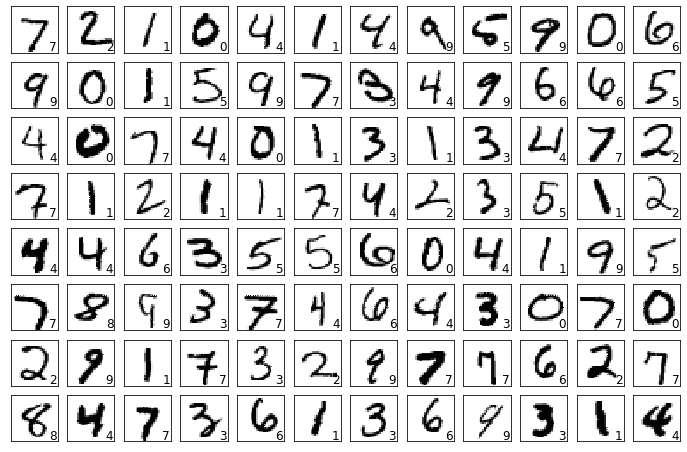

In [ ]:
## Test 에측 결과 확인(시각화)
show_prediction()
plt.show()

#### 결과 해석
- 약 99%의 정확도
- 최대 pooing층과 dropout층 정의 <br> 
  -> model.add(MaxPooling2D(pool_size = (2,2))<br>
  -> model.add(Dropout(0.25))<br>


- 테스트 데 이터의 처음 96개는 잘못된 인식 없이 모두 정답
- 더 큰 크키의 자연어 이미지를 처리하거나 카테고리로 심화될경우 층의 심층, 합성곱, 풀링, 드롭아웃 등의 효과는 더욱더 강력하게 나타날 것

#### Appdendix

- keras Network 구성요소: https://wikidocs.net/32105

- relu vs sigmoid : https://mongxmongx2.tistory.com/25 / https://gooopy.tistory.com/52

- 경사하강법 종류: https://aoc55.tistory.com/48